In [9]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import utils
from yieldcurve import YieldCurve
import cashflow as cf

In [25]:
portfolio, market = utils.load_data()
TODAY = utils.set_today()
portfolio

,account,account_name,volume,ir_binding,reprice_freq,spread,issue,maturity,repayment,payment_freq,yieldcurve
id,,,,,,,,,,,
1,cb_1,Cash and balances with central bank,930,FIX,1,5,2014-09-30,2014-10-01,BULLET,1,EUR01
2,mmp_1,Money market placements,1404,FIX,1,7,2014-08-30,2014-11-30,BULLET,1,EUR01
3,mmp_1,Money market placements,996,FIX,1,10,2014-06-15,2014-12-15,BULLET,1,EUR01
4,cl_1,Corporate loans,515,LIBOR,3,301,2014-05-15,2016-04-15,LINEAR,3,EUR01
5,cl_1,Corporate loans,655,LIBOR,6,414,2014-04-15,2016-04-15,LINEAR,6,EUR01
...,...,...,...,...,...,...,...,...,...,...,...
143,ret_td_1,Retail term deposit,-1229,FIX,1,48,2014-03-30,2015-08-30,BULLET,1,EUR01
144,ret_td_1,Retail term deposit,-2452,FIX,1,40,2014-02-28,2015-02-28,BULLET,1,EUR01
145,ret_td_1,Retail term deposit,-976,FIX,1,40,2014-01-28,2015-01-28,BULLET,1,EUR01


In [26]:
volume = 75000
maturity = 6
rate = 0.01
bull = cf.amortization_schedule(rate, maturity, volume, payment_type="BULLET")
lin = cf.amortization_schedule(rate, maturity, volume, payment_type='LINEAR')
ann = cf.amortization_schedule(rate, maturity, volume, payment_type='ANNUITY')

In [13]:
plot = False
EUR01 = YieldCurve(curve_type='EUR01', today=TODAY)
EUR01.fit(market, plot=plot)
date_list = utils.date_range('2016-01-01', '2035-01-01', 10)
spot_yields = EUR01.get_spot_yields(date_list, plot=plot)
forward_yields = EUR01.get_forward_yields(date_list, plot=plot)

date_list1 = utils.date_range('2016-01-01', '2035-01-01', 20)
date_list2 = utils.date_range('2016-01-01', '2035-01-01',10)
date_list2.append(datetime(2036,1,1))
floating_yields = EUR01.get_floating_yields(repayment_dates = date_list2, repricing_dates = date_list1, plot=plot)

In [14]:
cf.asset_cashflow(portfolio, market, 1, TODAY)

,id,account,date,cashflow,interest,capital,remaining
0,1,cb_1,2014-10-01,930.03875,0.03875,930.0,0.0


In [15]:
portfolio_cashflow = cf.portfolio_cashflow(portfolio, market, TODAY)
portfolio_cashflow

,id,account,date,cashflow,interest,capital,remaining
0,1,cb_1,2014-10-01,930.03875,0.03875,930.0,0.0
1,2,mmp_1,2014-10-30,0.08190,0.08190,0.0,1404.0
2,2,mmp_1,2014-11-30,1404.08190,0.08190,1404.0,0.0
3,3,mmp_1,2014-10-15,0.08300,0.08300,0.0,996.0
4,3,mmp_1,2014-11-15,0.08300,0.08300,0.0,996.0
...,...,...,...,...,...,...,...
10335,147,oth_l_1,2030-08-30,0.00000,-0.00000,0.0,-3930.0
10336,147,oth_l_1,2030-09-30,0.00000,-0.00000,0.0,-3930.0
10337,147,oth_l_1,2030-10-30,0.00000,-0.00000,0.0,-3930.0
10338,147,oth_l_1,2030-11-30,0.00000,-0.00000,0.0,-3930.0


In [16]:
present_values = cf.get_present_values(cashflows=portfolio_cashflow, market=market, today=TODAY)
present_values

,account,date,present_values
id,,,
1,cb_1,2014-09-30,930.038331
2,mmp_1,2014-09-30,1404.173476
3,mmp_1,2014-09-30,996.267185
4,cl_1,2014-09-30,530.700425
5,cl_1,2014-09-30,689.098535
...,...,...,...
143,ret_td_1,2014-09-30,-1235.085747
144,ret_td_1,2014-09-30,-2456.382170
145,ret_td_1,2014-09-30,-977.369632


In [17]:
cf.nii_table(portfolio_cashflow, today=TODAY)

year,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
account,,,,,,,,,,,,,,,,,
afs_1,6.988700,3.421667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
cb_1,0.038750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
cl_1,98.649849,230.729833,95.198928,34.657340,3.547923,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
cor_sd_1,-3.195833,-11.158333,-8.558333,-5.958333,-3.358333,-0.812500,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
cor_td_1,-5.596625,-1.993675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
is_1,-26.190199,-80.225486,-65.817673,-48.814757,-22.200196,-1.995362,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
mmp_1,0.412800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
mmt_1,-0.774925,-1.552539,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
oth_a_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0


In [18]:
cf.repricing_gap(portfolio, 11, TODAY, 13)

,volume
1,332
2,0
3,0
4,0
5,0
6,0
7,332
8,0
9,0
10,0


,1M,2M,3M,4M,5M,6M,7M,8M,9M,10M,11M,12M
volume,6100.0,9283.0,725.0,1787.0,7115.0,6560.0,1921.0,5919.0,2009.0,8649.0,6855.0,2730.0


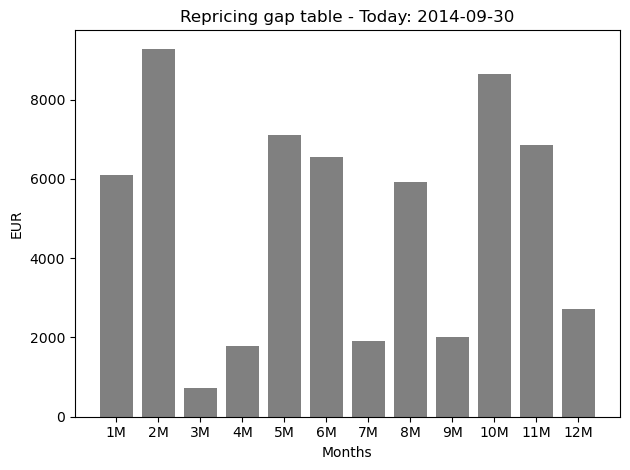

In [20]:
cf.repricing_gap_table(portfolio, today=TODAY, months_forward=12, plot=True)

In [22]:
table = portfolio_cashflow.pivot_table(index='date', columns='account', values='interest', aggfunc='sum').reset_index()
# table = table[table['date'] >= today]

# # Explicitly select numeric columns (excluding 'date' column) for the sum
# numeric_cols = table.select_dtypes(include=['number']).columns
# table['total'] = table[numeric_cols].sum(axis=1)

# table['year'] = table['date'].dt.year
# nii_table = table.groupby('year').sum().T

In [23]:
table

account,date,afs_1,cb_1,cl_1,cor_sd_1,cor_td_1,is_1,mmp_1,mmt_1,oth_a_1,oth_l_1,rep_1,ret_sd_1,ret_td_1,rm_1,ro_1
0,2014-10-01,NaN,0.03875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-10-14,0.624667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-10-15,1.858100,NaN,39.122949,NaN,NaN,-8.713951,0.0830,-0.122870,NaN,NaN,-0.05,NaN,NaN,NaN,NaN
3,2014-10-28,NaN,NaN,NaN,-1.083333,-0.759333,NaN,NaN,-0.136672,0.0,0.0,NaN,-2.75,-3.053725,136.964939,50.0
4,2014-10-30,NaN,NaN,NaN,NaN,-1.142625,NaN,0.0819,NaN,NaN,NaN,NaN,NaN,-0.904125,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,2030-08-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
330,2030-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
331,2030-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
332,2030-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [24]:
portfolio_cashflow

,id,account,date,cashflow,interest,capital,remaining
0,1,cb_1,2014-10-01,930.03875,0.03875,930.0,0.0
1,2,mmp_1,2014-10-30,0.08190,0.08190,0.0,1404.0
2,2,mmp_1,2014-11-30,1404.08190,0.08190,1404.0,0.0
3,3,mmp_1,2014-10-15,0.08300,0.08300,0.0,996.0
4,3,mmp_1,2014-11-15,0.08300,0.08300,0.0,996.0
...,...,...,...,...,...,...,...
10335,147,oth_l_1,2030-08-30,0.00000,-0.00000,0.0,-3930.0
10336,147,oth_l_1,2030-09-30,0.00000,-0.00000,0.0,-3930.0
10337,147,oth_l_1,2030-10-30,0.00000,-0.00000,0.0,-3930.0
10338,147,oth_l_1,2030-11-30,0.00000,-0.00000,0.0,-3930.0
